In [1]:
'''
Use the noise-to-noise to get the estimation of the noise
'''

'\nUse the noise-to-noise to get the estimation of the noise\n'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
import sys
import SimpleITK as sitk
import glob
import scipy.optimize
import scipy.ndimage
import skimage.metrics 

In [3]:
sys.path.append('..')
import CTProjector.projector.ct_projector as ct_projector
import model.unet as unet

In [49]:
import argparse
import configparser
parser = argparse.ArgumentParser()
parser.add_argument('--prj_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/prj_half/')
parser.add_argument('--ref_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/prj_half/')
parser.add_argument('--name', default = 'sino_81_2.a')
parser.add_argument('--geometry', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/geometry_hr.cfg')
parser.add_argument('--islices', type = int, nargs = 2, default = [90,91])
parser.add_argument('--N0', type = float, default = -1)
parser.add_argument('--dose_rate', type=float, default = 3)

parser.add_argument('--device', type = int, default = 0)
parser.add_argument('--img_norm', type = float, default = 0.019)
parser.add_argument('--train_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/l2_depth_3/')
parser.add_argument('--checkpoint', type=int, default = 50)
parser.add_argument('--tags', default = None)

parser.add_argument('--vmin', type=float, default = -0.16)
parser.add_argument('--vmax', type=float, default = 0.24)
parser.add_argument('--N0_ref', type=float, default = 5e5)
parser.add_argument('--filter', default = 'hann')
parser.add_argument('--margin', type=int, default = 96)
parser.add_argument('--noise_margin', type=int, default = 128)

if sys.argv[0] != 'noise2noise_ensemble.py':
    showplot = True
    args = parser.parse_args(['--device', '0', 
                              '--filter', 'ramp',
                              '--vmin', '-1.35',
                              '--vmax', '0.15',
                              '--N0_ref', '2e5',
                              '--islices', '50', '51',
                              '--tags', 'dose_rate_2,dose_rate_4,dose_rate_8,dose_rate_12,dose_rate_16,all',
                              '--checkpoint', '50',
#                               '--tags', 'L067,L096,L109,L192,L310,L286,all',
                             ])
else:
    showplot = False
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', getattr(args, k))

prj_dir = /home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/prj_half/
ref_dir = /home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/prj_half/
name = sino_81_2.a
geometry = /home/dwu/trainData/deep_denoiser_ensemble/data/dect_2d_3_layer_mean/geometry_hr.cfg
islices = [50, 51]
N0 = -1
dose_rate = 3
device = 0
img_norm = 0.019
train_dir = /home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/l2_depth_3/
checkpoint = 50
tags = dose_rate_2,dose_rate_4,dose_rate_8,dose_rate_12,dose_rate_16,all
vmin = -1.35
vmax = 0.15
N0_ref = 200000.0
filter = ramp
margin = 96
noise_margin = 128


In [50]:
os.environ['CUDA_VISIBLE_DEVICES'] = '%d'%args.device
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [51]:
# first load data and do reconstruction
projector = ct_projector.ct_projector()
projector.from_file(args.geometry)
projector.nv = 1
for k in vars(projector):
    print (k, '=', getattr(projector, k))
angles = projector.get_angles()

nview = 1152
nu = 736
nv = 1
nx = 640
ny = 640
nz = 1
dx = 0.75
dy = 0.75
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = 1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x2aaab79d63a0>


In [52]:
sitk_prjs = sitk.ReadImage(os.path.join(args.ref_dir, args.name + '.nii'))
prj = sitk.GetArrayFromImage(sitk_prjs)[args.islices[0]:args.islices[1]] / args.img_norm
prj = prj[:, :, np.newaxis, :] # insert the v dimension

# reconstruct full dose image
fprj = projector.ramp_filter(prj, args.filter)
ref = projector.fbp_fan_bp(fprj, angles) - 1

# noise insertion
np.random.seed(0)
if args.N0 > 0:
    prj = prj + np.sqrt((1 - 1 / args.dose_rate) * args.dose_rate * np.exp(prj * args.img_norm) / args.N0) * np.random.normal(size = prj.shape) / args.img_norm
    prj = prj.astype(np.float32)
else:
    sitk_prjs = sitk.ReadImage(os.path.join(args.prj_dir, args.name + '.nii'))
    prj = sitk.GetArrayFromImage(sitk_prjs)[args.islices[0]:args.islices[1]] / args.img_norm
    prj = prj[:, :, np.newaxis, :] # insert the v dimension

In [53]:
# random splitting
inds_offset = np.random.randint(0, 2, prj.shape[1]//2)
inds1 = np.arange(0, prj.shape[1], 2) + inds_offset
inds2 = np.arange(0, prj.shape[1], 2) + (1 - inds_offset)
fprj = projector.ramp_filter(prj, args.filter)
img1 = projector.fbp_fan_bp(np.copy(fprj[:, inds1, ...], 'C'), angles[inds1]) * 2
img2 = projector.fbp_fan_bp(np.copy(fprj[:, inds2, ...], 'C'), angles[inds2]) * 2
img = np.array([img1, img2]) - 1
noise_approx = (img1 - img2) / 2

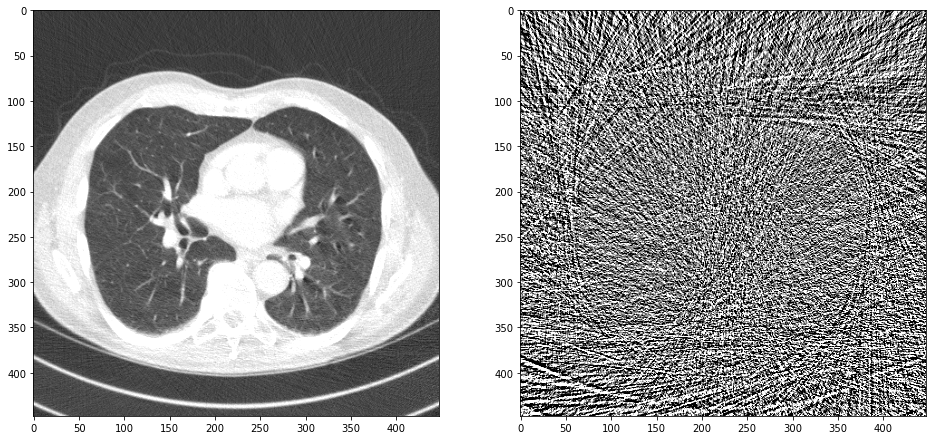

In [54]:
if showplot:
    plt.figure(figsize=[16,8])
    plt.subplot(121); plt.imshow(img.mean(0)[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(122); plt.imshow(noise_approx[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=-0.05, vmax=0.05)

In [55]:
K.clear_session()
# predict using the corresponding dose rate and the all dose rate
print ('Matched network', end=',')
dose_rate = int(args.dose_rate)
if dose_rate < 2:
    dose_rate = 2
elif dose_rate > 16:
    dose_rate = 16
checkpoint = os.path.join(args.train_dir, 'dose_rate_%d'%dose_rate, '50.h5')
model = tf.keras.models.load_model(checkpoint)
pred_matched = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[..., 0]
pred_matched = pred_matched[:, np.newaxis, :, :]

print ('Universal network', end=',')
checkpoint = os.path.join(args.train_dir, 'all/4.h5')
# checkpoint = os.path.join(args.train_dir, 'dose_rate_12/50.h5')
model = tf.keras.models.load_model(checkpoint)
pred_universal = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[..., 0]
pred_universal = pred_universal[:, np.newaxis, :, :]

Matched network,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Universal network,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


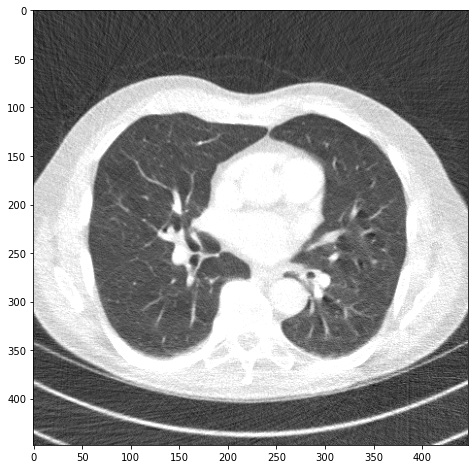

In [56]:
img_approx = pred_universal + noise_approx

plt.figure(figsize=[8,8])
plt.imshow(img_approx[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax)

In [57]:
# load models and generate denoising results
# list model directories
if args.tags is None:
    tags = [os.path.basename(s) for s in glob.glob(os.path.join(args.train_dir, 'dose_rate_*'))]
else:
    tags = args.tags.split(',')
# the list of denoised images
est_imgs = [img_approx]
base_imgs = [img.mean(0)]
print ('Predicting:', end=' ', flush=True)
for i, tag in enumerate(tags):
    print (i, end=',', flush=True)
    if tag == 'all':
        checkpoint = os.path.join(args.train_dir, tag, '4.h5')
    else:
        checkpoint = os.path.join(args.train_dir, tag, '%d.h5'%args.checkpoint)
    model = tf.keras.models.load_model(checkpoint)
    
    pred_est = model.predict(img_approx[:, 0, :, :, np.newaxis])[...,0]
    pred = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[...,0]
    
    pred_est = pred_est[:, np.newaxis, :, :]
    pred = pred[:, np.newaxis, :, :]
    
    est_imgs.append(pred_est)
    base_imgs.append(pred)
est_imgs = np.array(est_imgs)
base_imgs = np.array(base_imgs)

Predicting: 0,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
1,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
2,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
3,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
4,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
5,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


['dose_rate_2', 'dose_rate_4', 'dose_rate_8', 'dose_rate_12', 'dose_rate_16', 'all']


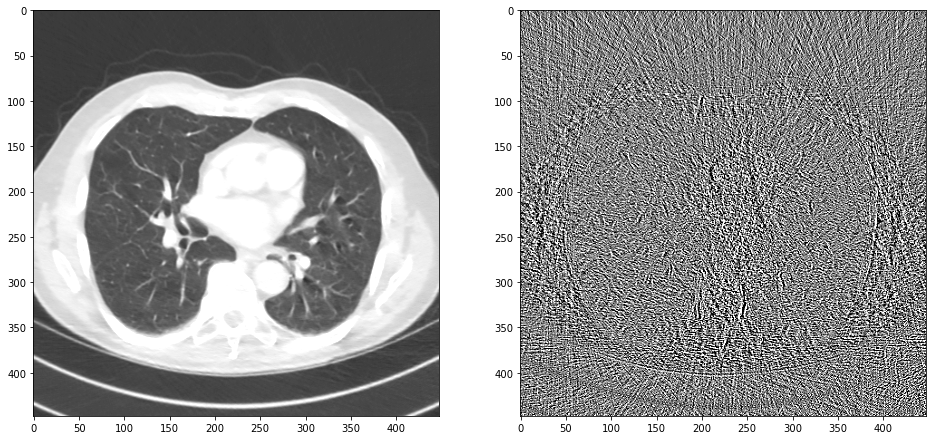

In [58]:
print (tags)
if showplot:
    plt.figure(figsize=[16,8])
    plt.subplot(121); plt.imshow(pred_universal[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(122); plt.imshow((img.mean(0) - pred_universal)[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=-0.05,vmax=0.05)

In [59]:
# estimate noise level of reference image
fp = projector.siddon_fan_fp(pred_universal + 1, angles)
recon_noiseless = projector.fbp_fan_bp(projector.ramp_filter(fp, args.filter), angles)-1

fp_noisy = -np.log(np.random.poisson(args.N0_ref * np.exp(-fp * args.img_norm)) / args.N0_ref) / args.img_norm
recon_noisy = projector.fbp_fan_bp(projector.ramp_filter(fp_noisy, args.filter), angles)-1

noise_level_pred = np.linalg.norm((img.mean(0) - pred_universal)[0,0,args.noise_margin:-args.noise_margin,args.noise_margin:-args.noise_margin])
noise_level_n2n = np.linalg.norm(noise_approx[0,0,args.noise_margin:-args.noise_margin,args.noise_margin:-args.noise_margin])
noise_level_ref = np.linalg.norm((recon_noisy - recon_noiseless)[0,0,args.noise_margin:-args.noise_margin,args.noise_margin:-args.noise_margin])

noise_ratio = noise_level_ref / noise_level_n2n

print (noise_level_pred, noise_level_n2n, noise_level_ref)

16.919289 23.145071 9.750376


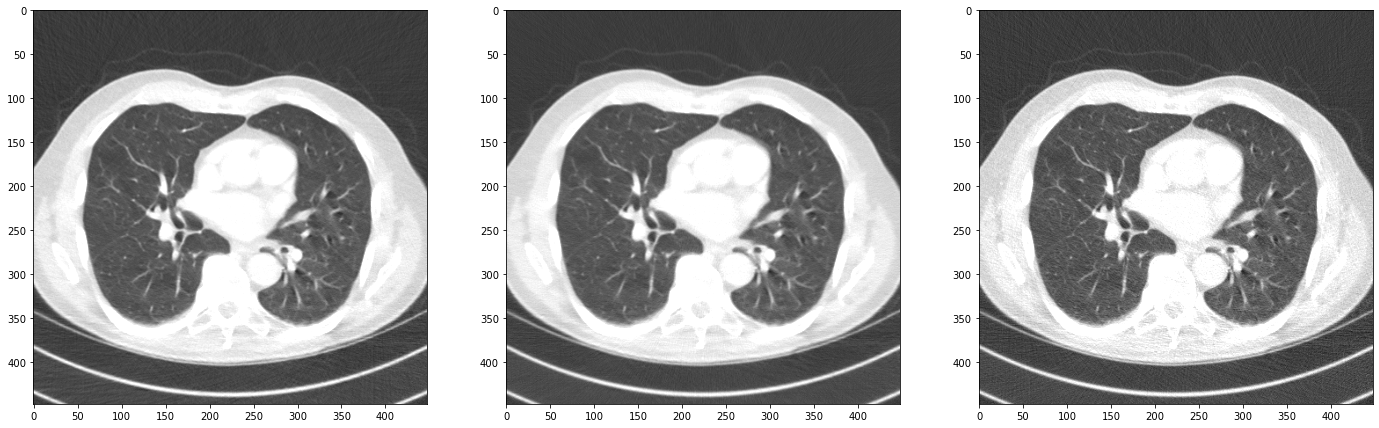

In [60]:
if showplot:
    plt.figure(figsize=[24,8])
    plt.subplot(131); plt.imshow((pred_universal + noise_level_ref / noise_level_n2n * noise_approx)[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray',
                                 vmin=args.vmin, vmax=args.vmax)
    plt.subplot(132); plt.imshow(recon_noisy[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(133); plt.imshow(ref[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray',  vmin=args.vmin, vmax=args.vmax)

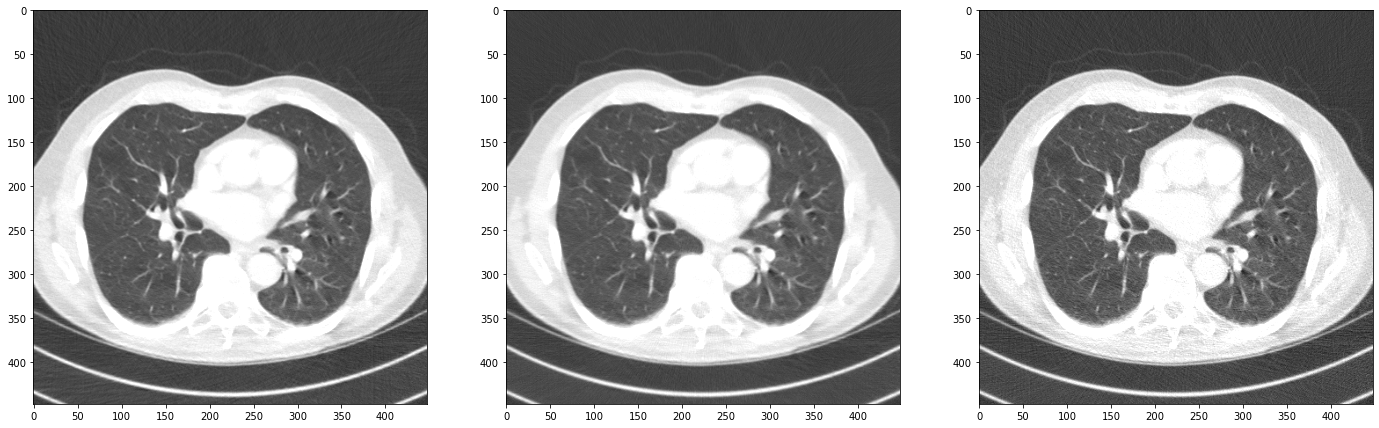

In [61]:
if showplot:
    plt.figure(figsize=[24,8])
    plt.subplot(131); plt.imshow((pred_universal + noise_level_ref / noise_level_n2n * noise_approx)[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray',
                                 vmin=args.vmin, vmax=args.vmax)
    plt.subplot(132); plt.imshow(recon_noisy[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax)
    plt.subplot(133); plt.imshow(ref[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray',  vmin=args.vmin, vmax=args.vmax)

In [62]:
def process(img, vmin=args.vmin, vmax=args.vmax):
    y = np.copy(img)
    y[y < vmin] = vmin
    y[y > vmax] = vmax
#     y = y - scipy.ndimage.gaussian_filter(y, 5)
    
    return y

In [63]:
M = np.zeros([len(est_imgs), len(est_imgs)])
b = np.zeros([len(est_imgs)])
# gamma = 0.04 * np.linalg.norm()
y = process(pred_universal + noise_ratio * noise_approx)
x = process(img_approx)

for k in range(len(base_imgs)):
#     if k > 0:
#         fk = process(x) - process(est_imgs[k])
#     else:
    fk = process(est_imgs[k])
    b[k] = np.sum(y * fk)
    for j in range(len(base_imgs)):
#         if j > 0:
#             fj = process(x) - process(est_imgs[j])
#         else:
        fj = process(est_imgs[j])
        M[k, j] = np.sum(fk * fj)
# c = np.linalg.solve(M, b)
c, _ = scipy.optimize.nnls(M, b)
# c = np.array([0.0, 0, 0, 0, 0, 1, 0])
print (c)
# base_vecs = [base_imgs[0]] + [img.mean(0) - b for b in base_imgs[1:]]
res = np.sum(base_imgs * c[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis], 0)

[0.27963622 0.         0.         0.         0.         0.5529837
 0.16610299]


In [64]:
# test auto blending
res_blend = pred_universal + (img.mean(0) - pred_universal) * noise_level_ref / noise_level_pred

In [65]:
# patchwise fitting
y = process(pred_universal + noise_ratio * noise_approx)
x = process(img_approx)

patchsize = [32,32]
res_p = np.zeros_like(img.mean(0))
for ix in range(20):
    for iy in range(20):
        M = np.zeros([len(est_imgs), len(est_imgs)])
        b = np.zeros([len(est_imgs)])
        
        sx = ix * patchsize[0]
        sy = iy * patchsize[1]
        
        xp = x[..., sx:sx+patchsize[0], sy:sy+patchsize[1]]
        yp = y[..., sx:sx+patchsize[0], sy:sy+patchsize[1]]
        
        for k in range(len(base_imgs)):
            fk = process(est_imgs[k][..., sx:sx+patchsize[0], sy:sy+patchsize[1]])
            b[k] = np.sum(yp * fk)
            for j in range(len(base_imgs)):
                fj = process(est_imgs[j][..., sx:sx+patchsize[0], sy:sy+patchsize[1]])
                M[k, j] = np.sum(fk * fj)
        
        if np.linalg.cond(M) < 1e10:
#             c = np.linalg.solve(M, b)
            c, _ = scipy.optimize.nnls(M, b)
        else:
            c = np.zeros([len(base_imgs)])
            c[0] = 1
        
#         print (c)
        
        res_p[..., sx:sx+patchsize[0], sy:sy+patchsize[1]] = np.sum(base_imgs[..., sx:sx+patchsize[0], sy:sy+patchsize[1]] * c[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis], 0)

In [66]:
# extags = np.array([1] + [int(s.split('_')[-1]) for s in tags])

In [67]:
loss_fbp = np.sqrt(np.mean((img.mean(0) - ref)[..., args.margin:-args.margin,args.margin:-args.margin]**2))
loss_n2n = np.sqrt(np.mean((res - ref)[..., args.margin:-args.margin,args.margin:-args.margin]**2))
loss_blend = np.sqrt(np.mean((res_p - ref)[..., args.margin:-args.margin,args.margin:-args.margin]**2))
loss_matched = np.sqrt(np.mean((pred_matched - ref)[..., args.margin:-args.margin,args.margin:-args.margin]**2))
loss_universal = np.sqrt(np.mean((pred_universal - ref)[..., args.margin:-args.margin,args.margin:-args.margin]**2))

print ('fbp:', loss_fbp)
print ('n2n:', loss_n2n)
print ('blend:', loss_blend)
print ('matched:', loss_matched)
print ('universal:', loss_universal)

fbp: 4.2826116e-07
n2n: 0.03264541417327461
blend: 0.030420378
matched: 0.022663044
universal: 0.043632865


In [68]:
def calc_ssim(x, y, vmin=args.vmin, vmax=args.vmax):
    x = (x - vmin) / (vmax - vmin)
    x[x < 0] = 0
    x[x > 1] = 1
    
    y = (y - vmin) / (vmax - vmin)
    y[y < 0] = 0
    y[y > 1] = 1
    
    return skimage.metrics.structural_similarity(x, y, data_range = 1)

In [69]:
ssim_fbp = calc_ssim(img.mean(0)[0, 0, args.margin:-args.margin,args.margin:-args.margin], ref[0,0,args.margin:-args.margin,args.margin:-args.margin])
ssim_n2n = calc_ssim(res[0, 0, args.margin:-args.margin,args.margin:-args.margin], ref[0,0,args.margin:-args.margin,args.margin:-args.margin])
ssim_blend = calc_ssim(res_p[0, 0, args.margin:-args.margin,args.margin:-args.margin], ref[0,0,args.margin:-args.margin,args.margin:-args.margin])
ssim_matched = calc_ssim(pred_matched[0, 0, args.margin:-args.margin,args.margin:-args.margin], ref[0,0,args.margin:-args.margin,args.margin:-args.margin])
ssim_universal = calc_ssim(pred_universal[0, 0, args.margin:-args.margin,args.margin:-args.margin], ref[0,0,args.margin:-args.margin,args.margin:-args.margin])

print ('fbp:', ssim_fbp)
print ('n2n:', ssim_n2n)
print ('blend:', ssim_blend)
print ('matched:', ssim_matched)
print ('universal:', ssim_universal)

fbp: 0.9999999999897548
n2n: 0.8886227749161487
blend: 0.9015339742351193
matched: 0.9499706491872257
universal: 0.7869241614487119


['dose_rate_2', 'dose_rate_4', 'dose_rate_8', 'dose_rate_12', 'dose_rate_16', 'all']


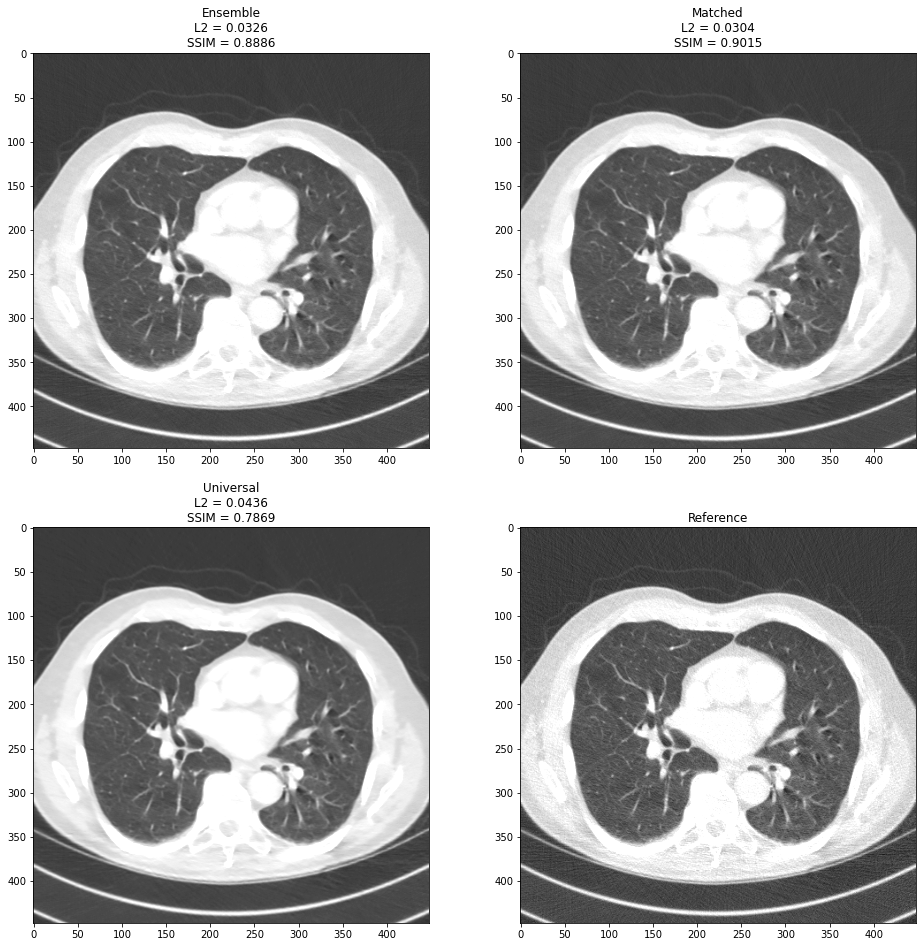

In [70]:
if showplot:
    print (tags)
    plt.figure(figsize=[16,16])
    plt.subplot(221); plt.imshow(res[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax); 
    plt.title('Ensemble\nL2 = %.4f\nSSIM = %.4f'%(loss_n2n, ssim_n2n))
    plt.subplot(222); plt.imshow(res_p[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray', vmin=args.vmin, vmax=args.vmax); 
    plt.title('Matched\nL2 = %.4f\nSSIM = %.4f'%(loss_blend, ssim_blend))
    plt.subplot(223); plt.imshow(pred_universal[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray',  vmin=args.vmin, vmax=args.vmax); 
    plt.title('Universal\nL2 = %.4f\nSSIM = %.4f'%(loss_universal, ssim_universal))
    plt.subplot(224); plt.imshow(ref[0,0,args.margin:-args.margin,args.margin:-args.margin].T, 'gray',  vmin=args.vmin, vmax=args.vmax); 
    plt.title('Reference')

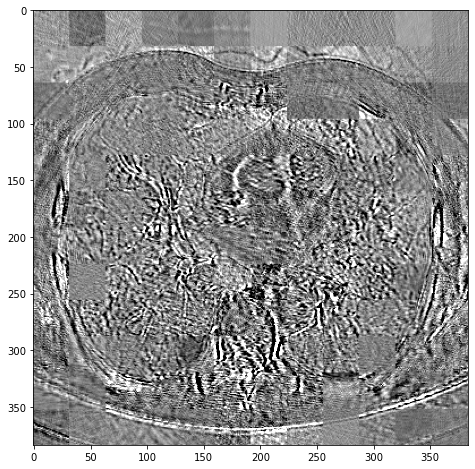

In [71]:
plt.figure(figsize=[8,8])
plt.imshow((res - res_p)[0,0,128:-128,128:-128].T, 'gray', vmin=-0.01, vmax=0.01)